# SureChEMBL iPython Notebook Tutorial 2

## An introduction to patent chemoinformatics using SureChEMBL data and the RDKit toolkit

### George Papadatos, ChEMBL group, EMBL-EBI

##In this tutorial:
1. Read a file that contains all chemistry extracted from the Levitra US patent (US6566360) along with *all* the other members of the same patent family.
2. Filter by different text-mining and chemoinformatics properties to remove noise and enrich the genuinely novel structures claimed in the patent documents. 
3. Visualise the chemical space using MDS and dimensionality reduction.  
i.  Identify outliers in the chemistry space.  
ii. Fix wrongly extracted structures.  
4. Find the Murcko and MCS scaffolds of the claimed compounds in the patent family.  
i.  Compare the derived core with the actual Markush structure as reported in the original patent document.
6. Identify **key** compounds using structural information only. This is based on the publications by [Hattori et al.](http://pubs.acs.org/doi/abs/10.1021/ci7002686) and [Tyrchan et al.](http://pubs.acs.org/doi/abs/10.1021/ci3001293).   
i.  Count the number of NNs per compound.  
ii. Perform R-Group decomposition.

In [1]:
%pylab inline
import pandas as pd

from IPython.display import display
from IPython.display import display_pretty, display_html, HTML, Javascript, Image

from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFMCS as MCS
from rdkit.Chem import Draw
Draw.DrawingOptions.elemDict[0]=(0.,0.,0.)  # draw dummy atoms in black

from itertools import cycle
from sklearn import manifold
from scipy.spatial.distance import *

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

# Get the base URL of the VM:
display(Javascript('IPython.notebook.kernel.execute("current_url = " + "\'"+document.URL+"\'");'))

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

In [2]:
from rdkit import rdBase
rdBase.rdkitVersion

'2016.03.1'

This is the base URL of the local Beaker server running on myChEMBL.

In [3]:
cur_base_url = current_url.split('http://')[1].split('/')[0]
base_url = 'localhost:8000' if (cur_base_url == 'localhost:9612' or cur_base_url == '127.0.0.1:9612') else current_url.split('http://')[1].split(':')[0] + ':8000'
base_url

'tannin.windows.ebi.ac.uk:8000'

In [4]:
pd.options.display.mpl_style = 'default'
pd.options.display.float_format = '{:.2f}'.format

In [5]:
rcParams['figure.figsize'] = 16,10

## 1. Read and filter the input file

The file was generated by extracting all chemistry from a list of patent documents in [SureChEMBL](https://www.surechembl.org). The Lucene query used to retrieve the list of relevant patents was: pn:"US6566360".

In [6]:
df = pd.read_csv('/home/chembl/ipynb_workbench/document_chemistry_20141011_114421_271.csv',sep=',')

Let's check the contents:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8497 entries, 0 to 8496
Data columns (total 28 columns):
Patent ID                    8497 non-null object
Annotation Reference         8497 non-null object
Chemical ID                  8497 non-null int64
SMILES                       8497 non-null object
Type                         8497 non-null object
Chemical Document Count      8497 non-null int64
Annotation Document Count    3372 non-null float64
Title Count                  3372 non-null float64
Abstract Count               3372 non-null float64
Claims Count                 3372 non-null float64
Description Count            3372 non-null float64
Chemical Corpus Count        8497 non-null int64
Annotation Corpus Count      3372 non-null float64
Molecular Weight             8497 non-null float64
Med Chem Alert               8497 non-null int64
Log P                        8497 non-null float64
Donor Count                  8497 non-null int64
Acceptor Count               8497 non-nu

In [8]:
df.shape

(8497, 28)

Add a SCHEMBL ID column and sort:

In [9]:
df['SCHEMBL ID'] = df['Chemical ID'].map(lambda x: 'SCHEMBL{0}'.format(x))
df = df.sort('Chemical ID')

In [10]:
df.iloc[600:610]

,Patent ID,Annotation Reference,Chemical ID,SMILES,Type,Chemical Document Count,Annotation Document Count,Title Count,Abstract Count,Claims Count,...,Rotatable Bound Count,Radical,Fragment,Connected,Singleton,Simple,Lipinski,Lead Likeness,Bio Availability,SCHEMBL ID
25,US-20050070541-A1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,1-f][1,2,4]triazin-4-one",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,2,2.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
778,US-20100016323-A1,US20100016323A1-20100121-C00062.MOL,5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,MOLATTACHMENT,2,nan,nan,nan,nan,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
6174,US-20080113972-A1,US20080113972A1-20080515-C00061.TIF,5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,IMAGE,2,nan,nan,nan,nan,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
7863,EP-2295436-A1,imgb0068.tif,5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,IMAGE,2,nan,nan,nan,nan,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
1103,US-7122540-B2,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,1-f][1,2,4]triazin-4-one",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,2,2.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
2418,US-6362178-B1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,1-f][1,2,4]triazin-4-one",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,2,2.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
8194,EP-1174431-B1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,1-f][1,2,4]trazin-4-on",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,2,1.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
8113,EP-1049695-A1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,l-f][l,2,4]-triazin-4-on",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,1,1.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
8196,EP-1174431-B1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,1-f][1,2,4]-triazin-4-on",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,2,1.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613
8418,WO-1999024433-A1,"2-(2-ethoxy-phenyl)-5-methyl-7-propyl-3h-imidazo[5,l-f][l,2,4]-triazin-4-on",5613,CCCC1=NC(C)=C2N1N=C(NC2=O)C1=CC=CC=C1OCC,TEXT,1,1.00,0.00,0.00,0.00,...,5,0,0,1,0,0,1,1,1,SCHEMBL5613


**First round of filtering: Novel compounds appear in the description or claims section of the document. Alternatively, they are extracted from images or mol files**

In [11]:
dff = df[(df['Claims Count'] > 0) | (df['Description Count'] > 0) | (df['Type'] != "TEXT")]

In [12]:
dff.shape

(8484, 29)

**Second round of filtering: Simple physicochemical properties and counts**

In [13]:
dff = dff[(dff['Rotatable Bound Count'] < 15) & (dff['Ring Count'] > 0) & (df['Radical'] == 0) & (df['Singleton'] == 0) & (df['Simple'] == 0)]

In [14]:
dff.shape

(8218, 29)

In [15]:
dff = dff[(dff['Molecular Weight'] >= 300) & (dff['Molecular Weight'] <= 800) & (dff['Log P'] > 0) & (dff['Log P'] < 7)]

In [16]:
dff.shape

(6711, 29)

**Third round of filtering: Using Global Corpus Count**

In [17]:
dff = dff[(dff['Chemical Corpus Count'] < 400) & ((dff['Annotation Corpus Count'] < 400) | (dff['Annotation Corpus Count'].isnull()))]

In [18]:
dff.shape

(6459, 29)

**Keep largest fragment and convert SMILES to RDKit molecules**

In [19]:
dff['SMILES'] = dff['SMILES'].map(lambda x: max(x.split('.'), key=len))

In [20]:
PandasTools.AddMoleculeColumnToFrame(dff, smilesCol = 'SMILES')

In [21]:
#dff.head(10)

**Fourth round of filtering: Remove duplicates based on Chemical IDs and InChI keys**

In [22]:
dff['InChI'] = dff['ROMol'].map(Chem.MolToInchi)
dff['InChIKey'] = dff['InChI'].map(Chem.InchiToInchiKey)

In [23]:
#dff.head()

In [24]:
dff = dff.drop_duplicates('Chemical ID')

In [25]:
dff.shape

(401, 32)

In [26]:
dff = dff.drop_duplicates('InChIKey')

In [27]:
dff.shape

(394, 32)

Wow, that was a lot of duplicates. This is because the same compounds come from different patents in the same patent family. In addition, in US patents a compound may come from 3 different sources: text, image and mol file. 

**Fifth round of filtering: Remove Boron-containing compounds as they are likely to be reactants.**

In [28]:
dff = dff.ix[~(dff['ROMol'] >= Chem.MolFromSmarts('[#5]'))]

In [29]:
dff.shape

(394, 32)

In [30]:
dff = dff.set_index('Chemical ID', drop=False)

That was the end of the filters - let's see a summary of the remaining compounds and their patent document source:

In [31]:
dff_counts = dff[['Patent ID','ROMol']].groupby('Patent ID').count()

In [32]:
dff_counts['Link'] = dff_counts.index.map(lambda x: '<a href="https://www.surechembl.org/document/{0}/" target="_blank">{0}</a>'.format(x))

In [33]:
dff_counts = dff_counts.rename(columns={'ROMol':'# Compounds'})

In [34]:
dff_counts

,# Compounds,Link
Patent ID,,
EP-1049695-A1,2,EP-1049695-A1
EP-1049695-B1,7,EP-1049695-B1
EP-1174431-A2,1,EP-1174431-A2
EP-2295436-A1,68,EP-2295436-A1
US-20040067945-A1,4,US-20040067945-A1
US-20050070541-A1,2,US-20050070541-A1
US-20060189615-A1,2,US-20060189615-A1
US-20080113972-A1,34,US-20080113972-A1
US-20100016323-A1,29,US-20100016323-A1


Right, is Levitra included in this set? ChEMBL tells me that its InChiKey is 'SECKRCOLJRRGGV-UHFFFAOYSA-N'.

,SCHEMBL ID,ROMol
Chemical ID,,
5441,SCHEMBL5441,

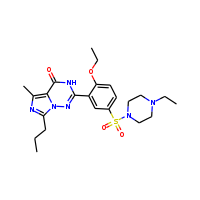

In [35]:
dff.ix[dff.InChIKey == 'SECKRCOLJRRGGV-UHFFFAOYSA-N',['SCHEMBL ID','ROMol']]

Good - it is...

## 2. Visualise the patent chemical space - MDS

Preparation of the pairwise distance matrix.

In [36]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in dff['ROMol']]

In [37]:
dist_mat = squareform(pdist(fps,'jaccard'))

In [38]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=3, n_jobs = 2)

In [39]:
results = mds.fit(dist_mat)

In [40]:
coords = results.embedding_

In [41]:
dff['X'] = [c[0] for c in coords]

In [42]:
dff['Y'] = [c[1] for c in coords]

In [43]:
csss = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #848482;
}
td
{
  background-color: #f2f3f4;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

In [44]:
import base64

In [45]:
dff['base64smi'] = dff['SMILES'].map(base64.b64encode)

Let's produce a scatter plot of the chemical space - points represent compounds, color-coded by the patent document they were found in. Thanks to [mpld3](http://mpld3.github.io/), the scatter plot is interactive with *live* structure rendering calls to the *local* myChEMBL Beaker server. 

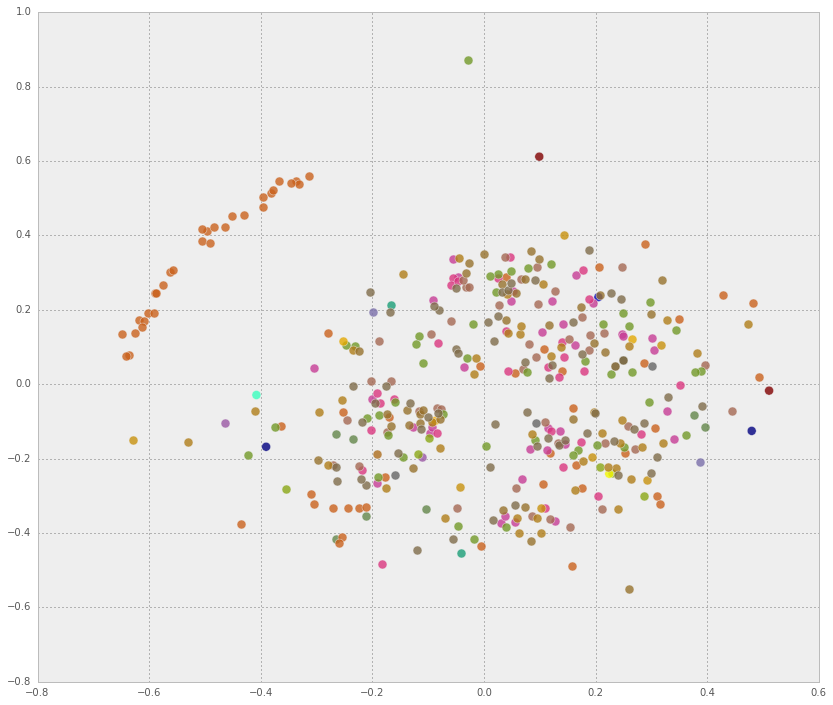

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(14.0, 12.0)
#colors = cycle('bgrcmykwbgrcmykbgrcmykwbgrcmykw')
colors = cycle(cm.Dark2(np.linspace(0,1,len(dff_counts.index))))
for name, group in dff.groupby('Patent ID'):
    labels = []
    for i in group.index:
        zz = group.ix[[i],['Patent ID','SCHEMBL ID','base64smi']]
        zz['mol'] = zz['base64smi'].map(lambda x: '<img src="http://{0}/utils/smiles2image/{1}?size=300">'.format(base_url,x))
        del zz['base64smi']
        label = zz.T
        del zz
        label.columns = ['Row: {}'.format(i)]
        labels.append(str(label.to_html()))
    points = ax.scatter(group['X'], group['Y'],c=colors.next(), s=80, alpha=0.8)
    tooltip = mpld3.plugins.PointHTMLTooltip(points, labels, voffset=10, hoffset=10, css=csss)
    mpld3.plugins.connect(fig,tooltip)                                          

Nice, we get Beaker rendering on the fly. However, there is a bunch of compounds on the left that are distinctively different. This is because of an image extraction error.  
At least the error is systematic: extraction breaks the imidazole ring. Let's try to 'repair' the ring and rescue these compounds - we'll use an appropriate intramolecular reaction SMARTS.

In [47]:
resmarts = "([R:5][C;!R:1]=[C;H2].[C;H0,H1;!R:4]-[N;H2:2])>>[R:5][*:1]=[*:2]-[*:4]"

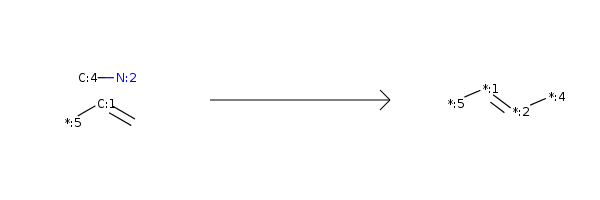

In [48]:
Draw.ReactionToImage(Chem.ReactionFromSmarts(resmarts))

In [49]:
def fixRing(mol,resmarts=resmarts):
    rxn = Chem.ReactionFromSmarts(resmarts)
    ps = rxn.RunReactants((mol,))
    if ps:
        m = ps[0][0]
        Chem.SanitizeMol(m)
        return m
    else:
        return mol

So this...

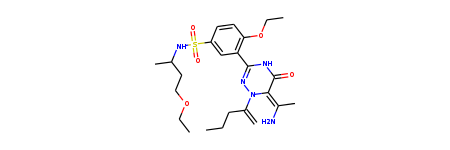

In [50]:
mm = dff.ix[12823029]['ROMol']
mm

...will become this:

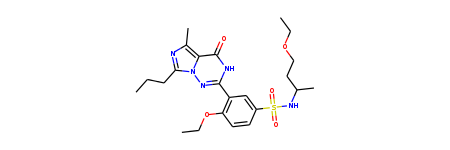

In [51]:
fixRing(mm)

Let's apply the repair to all affected structures:

In [52]:
for i, p, m in zip(dff.index, dff['Patent ID'], dff['ROMol']):
    if p == 'EP-2295436-A1':
        dff.ix[i,'ROMol'] = fixRing(m)

In [53]:
dff['InChI'] = dff['ROMol'].map(Chem.MolToInchi)
dff['InChIKey'] = dff['InChI'].map(Chem.InchiToInchiKey)
dff = dff.drop_duplicates('InChIKey')

So after the fix, we have even less structures because some of the fixed ones already existed. Hopefully, however, we have less false positives too:

In [54]:
dff.shape

(363, 35)

In [55]:
dff['RD_SMILES'] = dff['ROMol'].map(Chem.MolToSmiles)
dff['base64rdsmi'] = dff['RD_SMILES'].map(base64.b64encode)

We're going to re-calculate the distance matrix and plot the MCS just to double-check they were no side-effects from the applications of the reaction.

In [56]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) for m in dff['ROMol']]
dist_mat = squareform(pdist(fps,'jaccard'))
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=3, n_jobs = 2)
results = mds.fit(dist_mat)
coords = results.embedding_
dff['X'] = [c[0] for c in coords]
dff['Y'] = [c[1] for c in coords]

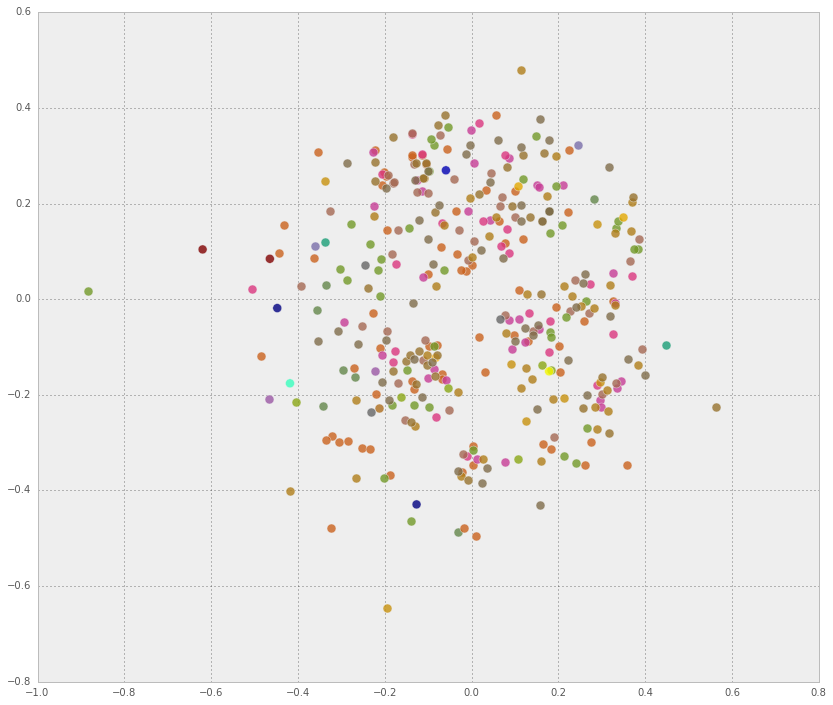

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(14.0, 12.0)
#colors = cycle('bgrcmykwbgrcmykbgrcmykwbgrcmykw')
colors = cycle(cm.Dark2(np.linspace(0,1,len(dff_counts.index))))
for name, group in dff.groupby('Patent ID'):
    labels = []
    for i in group.index:
        zz = group.ix[[i],['Patent ID','SCHEMBL ID','base64rdsmi']]
        zz['mol'] = zz['base64rdsmi'].map(lambda x: '<img src="http://{0}/utils/smiles2image/{1}?size=300">'.format(base_url,x))
        del zz['base64rdsmi']
        label = zz.T
        del zz
        label.columns = ['Row: {}'.format(i)]
        labels.append(str(label.to_html()))
    points = ax.scatter(group['X'], group['Y'],c=colors.next(), s=80, alpha=0.8)
    tooltip = mpld3.plugins.PointHTMLTooltip(points, labels, voffset=10, hoffset=10, css=csss)
    mpld3.plugins.connect(fig,tooltip)  

So the "island" of outliers has disappeared. There's only one obvious outlier on the far left. This might be a reactant which wasn't filtered out. 

## 3. Define the MCS for this set of claimed molecules

A couple of helper functions, inspired by Greg Landrum's post [here](http://rdkit.blogspot.co.uk/2015/05/a-set-of-scaffolds-from-chembl-papers.html).

In [58]:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,350),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    
    rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    # the MolDraw2D code is not very good at the moment at dealing with atom queries,
    # this is a workaround until that's fixed.
    # The rendering is still not going to be perfect because query bonds are not properly indicated
    opts = drawer.drawOptions()
    for atom in mc.GetAtoms():
        if atom.HasQuery() and atom.DescribeQuery().find('AtomAtomicNum')!=0:
            opts.atomLabels[atom.GetIdx()]=atom.GetSmarts()
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [59]:
def MCS_Report(ms,atomCompare=MCS.AtomCompare.CompareAny,**kwargs):
    mcs = MCS.FindMCS(ms,atomCompare=atomCompare,completeRingsOnly=True,timeout=120,**kwargs)
    nAts = np.array([x.GetNumAtoms() for x in ms])
    print 'Mean nAts: {0}, mcs nAts: {1}'.format(nAts.mean(),mcs.numAtoms)
    print 'MCS SMARTS: {0}'.format(mcs.smartsString)
    mcsM = Chem.MolFromSmarts(mcs.smartsString)
    
    mcsM.UpdatePropertyCache(False)
    Chem.SetHybridization(mcsM)
    Chem.Compute2DCoords(mcsM)
    smi = Chem.MolToSmiles(mcsM,isomericSmiles=True)
    print "MCS SMILES: {0}".format(smi)
    img=Draw.MolToImage(mcsM,kekulize=False)
    return mcs.smartsString,smi,img,mcsM

Let's add the Murcko framework to our data frame:

In [60]:
PandasTools.AddMurckoToFrame(dff)

In [61]:
PandasTools.AddMoleculeColumnToFrame(dff,smilesCol='Murcko_SMILES', molCol='MurMol')

In [62]:
PandasTools.AlignToScaffold(dff)

,ROMol,MurMol
Chemical ID,,
5441,,
5517,,
5530,,
5537,,
5606,,

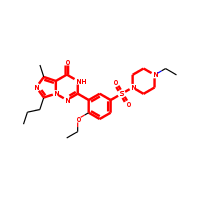
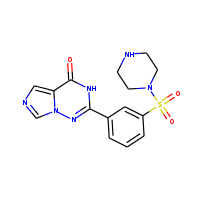
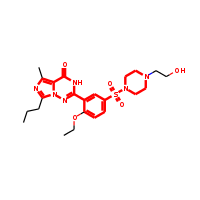
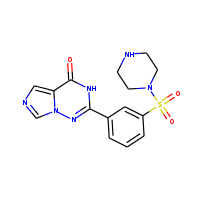
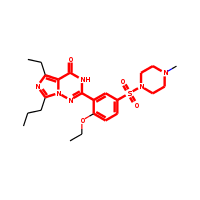
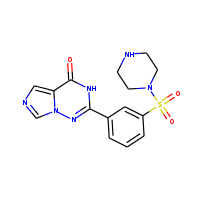
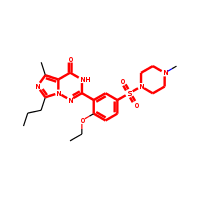
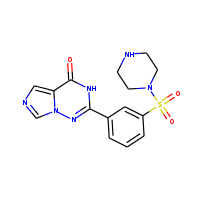
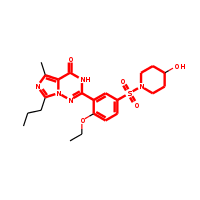
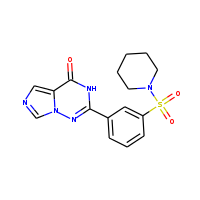

In [63]:
dff[['ROMol','MurMol']].head()

And now we'll extract the MCS core:

Mean nAts: 24.6914600551, mcs nAts: 16
MCS SMARTS: [#8]=[#6]1:[#7]:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#7]2:[#6]:1:[#6]:[#7,#6]:[#6]:2
MCS SMILES: O=C1:N:C(C2:C:C:C:C:C:2):N:N2:C:N:C:C:1:2


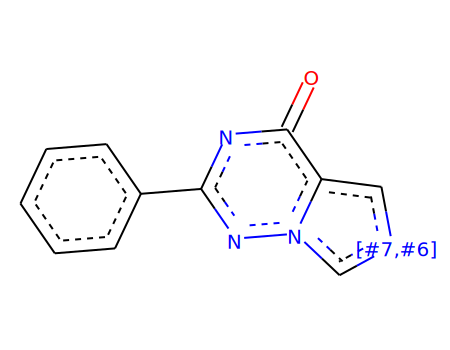

In [64]:
mols = list(dff.MurMol)
smarts,smi,img,mcsM = MCS_Report(mols,threshold=0.8,ringMatchesRingOnly=True)
SVG(moltosvg(mcsM))

## 4. Compare the extracted MCS core with the actual claimed Markush structure.

Given the MCS core, we'll do an R-Group decomposition first to define the R-Groups and their attachement points.

In [65]:
core = Chem.MolFromSmarts(smarts)    

In [66]:
pind = []
rgroups = []
for i, m in zip(dff.index, dff.ROMol):
    rgrps = Chem.ReplaceCore(m,core,labelByIndex=True)
    if rgrps:
        s = Chem.MolToSmiles(rgrps, True)
        for e in s.split("."):
            pind.append(e[1:4].replace('*','').replace(']',''))
            rgroups.append(e)
        #print "R-Groups: ", i, s

In [67]:
pind = sorted(list(set(pind)),key=int)

In [68]:
pind = map(int,pind)

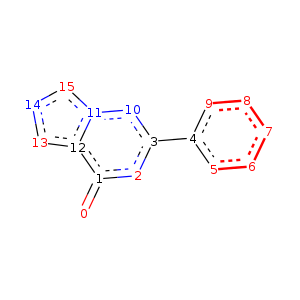

In [69]:
Draw.MolToImage(core,includeAtomNumbers=True,highlightAtoms=pind)

Is the MCS similar to the claimed Markush structure?
Let's fetch the original document in PDF and check in page 4:

In [70]:
HTML('<iframe src=https://dl.dropboxusercontent.com/u/22273283/US6566360B1.pdf width=1000 height=500></iframe>')

Pretty close!

## 5. Identify key compounds - in this case, vardenafil itself

This is based on the publication by [Hattori et al.](http://pubs.acs.org/doi/abs/10.1021/ci7002686) and [Tyrchan et al.](http://pubs.acs.org/doi/abs/10.1021/ci3001293). First we'll try the Hattori et al. version of finding the compounds with the highest number of nearest neighbours (NNs) for a given similarity threshold. We will need to calculate the similarity matrix.

In [71]:
sim_mat = []
CUTOFF = 0.8
for i,fp in enumerate(fps):
    tt = DataStructs.BulkTanimotoSimilarity(fps[i],fps)
    for i,t in enumerate(tt):
        if tt[i] < CUTOFF:
            tt[i] = None
    sim_mat.append(tt)
sim_mat=numpy.array(sim_mat) 

In [72]:
sim_df = pd.DataFrame(sim_mat, columns = dff['Chemical ID'], index=dff['Chemical ID'])

In [73]:
sim_df.head()

Chemical ID,5441,5517,5530,5537,5606,5613,5673,12070,13527,13579,13598,13607,13631,13694,13812,13825,13848,14279,972506,972565,972730,973032,973183,973241,973332,973348,973349,973382,973386,973387,973603,973661,973671,973678,973718,973727,973746,973867,973955,974006,974073,974080,974182,974189,974215,974259,974265,974295,974365,974554,974562,974563,974600,974749,974752,974824,974886,975008,975154,975172,975193,975207,975233,975270,975295,975296,975385,975388,975390,975490,975627,1456170,1456512,1457300,3173334,3182150,4338924,4580977,5931932,5949554,6400765,6793077,7126552,7130126,7419685,7601429,8251760,8255604,8256987,8259092,12822592,12822595,12822605,12822651,12822661,12822664,12822668,12822851,12822865,12822870,12822871,12822873,12822881,12822901,12822909,12822916,12823010,12823018,12823023,12823025,12823027,12823028,12823029,12823050,12823052,12823062,12823071,12823075,12823076,12823078,12823080,12823083,12823089,12823092,12823099,12823105,12823108,12823115,12823120,12823122,12823128,12823129,12823132,12823133,12823134,12823135,12823139,12823141,12823147,12823154,12823156,12823172,12823185,12823190,12823225,12823228,12823229,12823233,12823240,12823262,12823273,12823289,12823297,12823314,12823320,12823321,12823325,12823326,12823329,12823330,12823342,12823354,12823372,12823405,12823411,12823425,12823426,12823511,12823517,12823522,12823528,12823541,12823546,12823547,12823550,12823557,12823559,12823560,12823564,12823567,12823579,12823582,12823596,12823601,12823604,12823607,12823609,12823610,12823611,12823614,12823621,12823625,12823626,12823629,12823632,12823633,12823634,12823635,12823636,12823637,12823642,12823643,12823644,12823645,12823648,12823650,12823652,12823654,12823739,12823745,12823752,12823756,12823757,12823758,12823762,12823763,12823764,12823765,12823767,12823768,12823769,12823770,12823771,12823772,12823773,12823774,12823775,12823777,12823778,12823779,12823781,12823786,12823790,12823791,12823792,12823793,12823795,12823796,12823797,12823799,12823800,12823801,12823802,12823805,12823808,12823810,12823815,12823816,12823818,12823819,12823821,12823823,12823967,12823974,12823977,12823978,12823982,12823983,12823984,12823985,12823986,12823987,12823988,12823992,12823998,12823999,12824000,12824002,12824003,12824004,12824005,12824006,12824007,12824008,12824009,12824010,12824011,12824012,12824013,12824016,12824017,12824018,12824022,12824024,12824026,12824028,12824029,12824030,12824031,12824034,12824035,12824036,12824037,12824038,12824040,12824041,12824042,12824044,12824047,12824049,12824053,12824055,12824057,12824059,12824060,12824062,12824063,12824064,12824065,12824066,12824067,12824068,12824069,12824070,12824071,12824072,12824073,12824074,12824080,12824081,12824085,12824086,12824087,12824089,12922516,12922517,12922519,12922520,12922521,12922522,12922527,12922529,12922530,12922536,12922538,12922546,12922547,12922549,12922550,12922555,12922558,12922560,12922561,12922563,12922566,12922567,12922569,12922570,12922574,12922577,12922578,12922579,13401084,13401207,13401208,13435578,13533556,14199034,14278252,14278326,14301695,14752321,14752362
Chemical ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5441,1.00,0.86,None,0.87,0.80,None,None,None,None,None,None,None,None,0.87,None,None,None,None,None,None,0.83,None,None,None,None,None,None,None,None,None,None,None,None,0.83,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.85,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.84,None,None,None,None,None,None,None,None,None,0.81,0.83,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No

In [74]:
d = sim_df.count().to_dict()
nn_df = pd.DataFrame(d.items(),columns=['Chemical ID', '# NNs'])
nn_df.set_index('Chemical ID',inplace=True)
nn_df.head()

,# NNs
Chemical ID,
975193,5
974886,3
1456170,1
12822592,2
12822595,1


,Chemical ID,ROMol,# NNs
Chemical ID,,,
12823654,12823654,,23
5441,5441,,22
12824064,12824064,,21
5537,5537,,21
12822873,12822873,,18

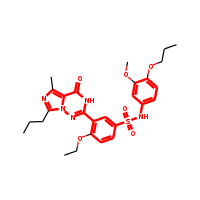
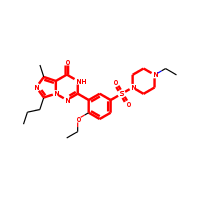
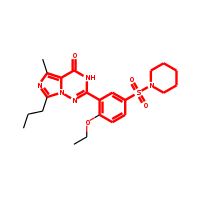
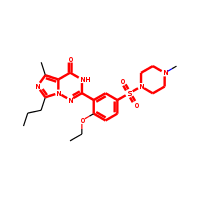
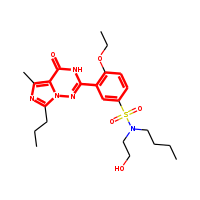

In [75]:
pd.merge(dff[['Chemical ID','ROMol']],nn_df,left_index=True, right_index=True, sort=False).sort('# NNs',ascending=False).head()

So, the method seems to be working in this case. Vardenafil has the second largest number of NNs with a cutoff of 0.8. Next, we'll try one of the Tyrchan et al. methods (Frequency of Groups, FOG) and count the frequency of the derived R-Groups:

In [76]:
from collections import Counter
rgroups = [r.replace('[9*]','[5*]').replace('[8*]','[6*]') for r in rgroups]
c = Counter(rgroups)

In [77]:
rgroup_counts = pd.DataFrame(c.most_common(20),columns=['RGroups','Frequency'])
rgroup_counts.head(10)

,RGroups,Frequency
0,[15*]CCC,349
1,[5*]OCC,306
2,[13*]C,294
3,[13*]CC,63
4,[5*]OCCC,28
5,[5*]O,16
6,[15*]C,10
7,[7*]OC,8
8,[6*]S(=O)(=O)N1CCN(C)CC1,8
9,[6*]S(=O)(=O)N(CC)CCO,7


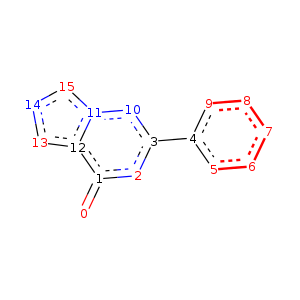

In [78]:
Draw.MolToImage(core,includeAtomNumbers=True,highlightAtoms=pind)

,RGroups,Frequency,ROMol
0,[15*]CCC,349,
1,[5*]OCC,306,
2,[13*]C,294,
3,[13*]CC,63,
4,[5*]OCCC,28,
5,[5*]O,16,
6,[15*]C,10,
7,[7*]OC,8,
8,[6*]S(=O)(=O)N1CCN(C)CC1,8,
9,[6*]S(=O)(=O)N(CC)CCO,7,

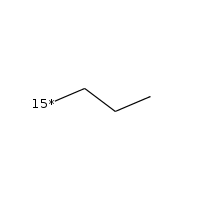
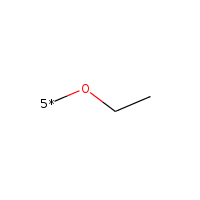
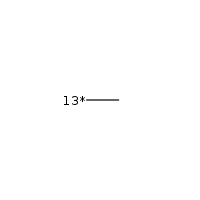
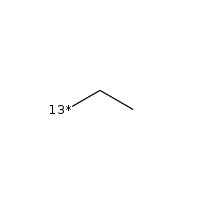
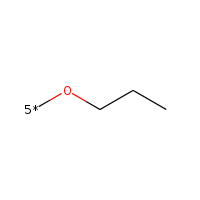
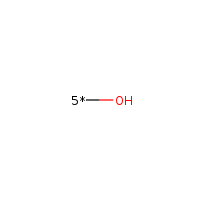
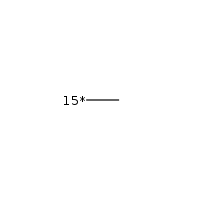
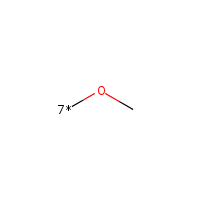
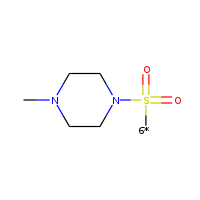
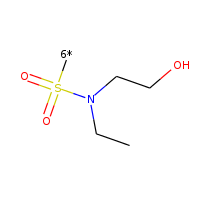

In [79]:
PandasTools.AddMoleculeColumnToFrame(rgroup_counts, smilesCol = 'RGroups')
rgroup_counts.head(10)

,RGroups,Frequency,ROMol
8,[6*]S(=O)(=O)N1CCN(C)CC1,8,
9,[6*]S(=O)(=O)N(CC)CCO,7,
10,[6*]S(=O)(=O)Cl,6,
11,[6*]S(=O)(=O)N1CCN(CC)CC1,4,
12,[6*]S(=O)(=O)N1CCC(O)CC1,4,
13,[6*]S(=O)(=O)NCCCN1CCOCC1,4,
14,[6*]S(=O)(=O)N(CC)CC,4,
15,[6*]S(=O)(=O)N1CCN(CCO)CC1,4,
16,[6*]S(=O)(=O)N(C)CCN(C)C,3,
17,[6*]S(=O)(=O)N1CCN(C(C)C)CC1,3,

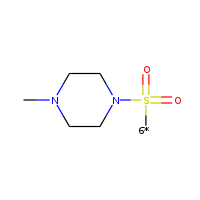
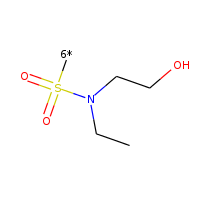
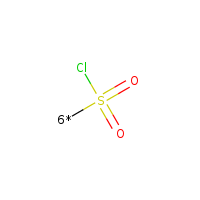
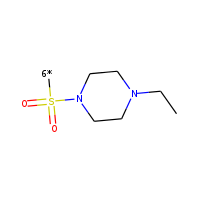
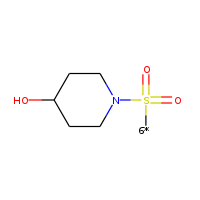
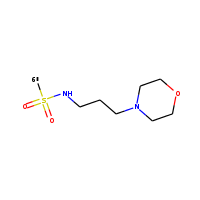
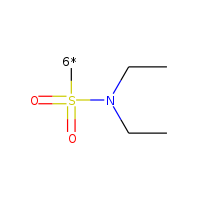
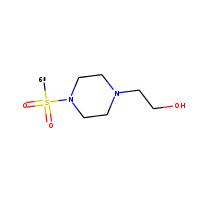
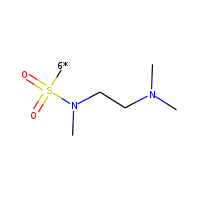
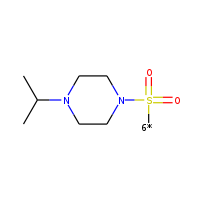

In [80]:
rgroup_counts[[r.startswith('[6*]') for r in rgroup_counts.RGroups]].head(10)

Although the most frequent R-groups in positions 9 and 11 correspond to those in Vardenafil (see below), the exact piperazine R-group in position 6 is the 5th most frequent one in that position.

,SCHEMBL ID,ROMol
Chemical ID,,
5441,SCHEMBL5441,

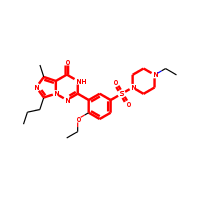

In [81]:
dff.ix[dff.InChIKey == 'SECKRCOLJRRGGV-UHFFFAOYSA-N',['SCHEMBL ID','ROMol']]